In [1]:
import numpy as np
import random
from tqdm import tqdm
from copy import deepcopy

from utils.reproduce_functions import *
from utils.mutation_functions import *
from utils.parent_selection_functions import *
from utils.other_fucntions import *
from utils.valhalla_functions import *
from utils.island_functions import *

import lab9_lib

In [2]:
PROBLEM_SIZE = 10

MU = 15
LAMBDA = 30
strategy = 'plus' # comma or plus

MUTATION_PROB = 0.2
DYNAMIC_MUTATION_PROB = True
DIVERSITY_THRESHOLD = 20

LENGTH_SOLUTION = 1000
NUMBER_GENERATIONS = 3000

EPOCH = 10              # Number of generation to reintroduce the best fitting
N_CHAMPIONS = 30        # Number of champions that will rest in the Valhalla
NUM_ISLANDS = 5                       # Number of different populations
N_MIGRANTS = 5                      # Number of migrants from one island

COOLDOWN_TIME = 100

In [3]:
mutate = one_bit_flip
reproduce = two_cuts_crossover
parent_selection = roulette
when_to_pick = fixed_generations
when_load_valhalla = fixed_generations

when_to_swap = fitness_based 
swap_individuals_between_islands = random_swap

In [4]:
def ga(fitness, islands, islands_evals, memoization=False, history=None):
    generation_convergence = -1
    valhalla = []
    valhalla_evals = [] 
    
    best_value = -1 
    last_change = 0
    
    if memoization:
        pop_history = {}
        for i in range(len(islands_evals)):
            for j in range(len(islands_evals[i])):
                pop_history[islands[i][j].tobytes()] = islands_evals[i][j]

    for generation in tqdm(range(NUMBER_GENERATIONS)):
        for island_ix, island in enumerate(islands):
            parents = island
            parents_evals = islands_evals[island_ix]
            offsprings = []
            offsprings_evals = []
            while len(offsprings) < LAMBDA:
                # Parent Selection
                p1, p2 = parent_selection(parents, parents_evals)

                # Reproduce Parents
                off_spring = reproduce(p1, p2)

                # Mutate Offspring
                if DYNAMIC_MUTATION_PROB:
                    p_div = get_parents_diversity(p1, p2)
                    new_ind1 = mutate(off_spring, \
                                    mutation_probability=(1 - (min(p_div,LENGTH_SOLUTION/2)/(LENGTH_SOLUTION/2))) )
                else:    
                    new_ind1 = mutate(off_spring, mutation_probability=MUTATION_PROB)

                # Evaluate Offspring
                if memoization:
                    new_ind1_eval = pop_history.get(new_ind1.tobytes())
                    if new_ind1_eval == None:
                        new_ind1_eval = fitness(new_ind1)
                        pop_history[new_ind1.tobytes()] = new_ind1_eval
                else:
                    new_ind1_eval = fitness(new_ind1)

                # Add it to new population
                offsprings.append(new_ind1)
                offsprings_evals.append(new_ind1_eval)


            # Create new population (with parents if plus, without if comma)
            all_people = (parents if strategy=='plus' else []) + offsprings
            all_evals = (parents_evals if strategy=='plus' else []) + offsprings_evals
            best_people = np.argsort(all_evals)[::-1]

            if history is not None:
                history[island_ix].append(np.max(all_evals))

            parents = []
            parents_evals = []
            for i in range(MU):
                parents.append(all_people[best_people[i]])
                parents_evals.append(all_evals[best_people[i]])
            islands[island_ix] = parents
            islands_evals[island_ix] = parents_evals
            
            if np.max(parents_evals) - 1.0 >= 0 and generation_convergence == -1:
                generation_convergence = generation, fitness.calls

        best_eval = max([max(x) for x in history])
        if best_eval > best_value:
            best_value = best_eval
            last_change = generation
        elif generation - last_change > COOLDOWN_TIME:
            break

        
        if when_to_pick(generation, 25):
            for island_ix, island in enumerate(islands):
                population = island
                population_evals = islands_evals[island_ix]
                
                max_index = np.argmax(population_evals)
                min_valhalla = np.min(valhalla_evals) if len(valhalla) > 0 else -1
                if population_evals[max_index] > min_valhalla:
                    best_individual = population.pop(max_index)
                    best_ind_eval = population_evals.pop(max_index)

                    valhalla.append(best_individual)
                    valhalla_evals.append(best_ind_eval)
            
            # if valhalla too big, empty it by migrating to islands
            while (len(valhalla)) > N_CHAMPIONS:
                champ_idx = np.random.randint(0, len(valhalla))
                champ = valhalla.pop(champ_idx)
                champ_eval = valhalla_evals.pop(champ_idx)

                island_idx = np.random.randint(len(islands))
                islands[island_idx].append(champ)
                islands_evals[island_idx].append(champ_eval)



        # if when_to_swap(generation, 10):
        #     # swap_individuals_between_islands(islands, islands_evals)
        #     swap_individuals_between_islands(islands)


        if when_to_swap(islands_evals):
            # swap_individuals_between_islands(islands, islands_evals)
            swap_individuals_between_islands(islands)
            
            # offsprings = np.array(offsprings)
            # offsprings_evals = np.array(offsprings_evals)
            # champions = offsprings[np.argsort(offsprings_evals)[-N_CHAMPIONS:]]
            # start = (((generation - 1) % EPOCH) // 10) * N_CHAMPIONS
            # end = (((generation - 1) % EPOCH) // 10) * N_CHAMPIONS + N_CHAMPIONS
            # valhalla[start:end, :] = offsprings[np.argsort(offsprings_evals)[-N_CHAMPIONS:]]
            # valhalla_evals[start:end] = offsprings_evals[np.argsort(offsprings_evals)[-N_CHAMPIONS:]]

        # if when_load_valhalla(generation, EPOCH):
        #     parents = list(np.concatenate((parents, valhalla)))
        #     parents_evals = list(np.concatenate((parents_evals, valhalla_evals)))
            # # Introduce some randomicity in order to inject champions from time to time.
            # if random.random() < 0.8:
            #     parents = np.concatenate((parents, random.choices(valhalla, k = 4)))


    return islands, islands_evals, valhalla, valhalla_evals

In [5]:
fitness_calls = []
best_scores = []
for i in range(100):
    fitness = lab9_lib.make_problem(PROBLEM_SIZE)

    islands = [ [generate_random_individual(length=LENGTH_SOLUTION) for _ in range(50) ] for _ in range(NUM_ISLANDS) ]
    islands_evals = [[fitness(x) for x in island] for island in islands]
    history = [[] for _ in range(NUM_ISLANDS)]
    islands, islands_evals, valhalla, valhalla_evals = ga(fitness, islands, islands_evals, memoization=True, history=history)

    print("Best score: ", max([max(x) for x in history] + valhalla_evals))
    print("Num fitness calls: ", fitness.calls)
    fitness_calls.append(fitness.calls)
    best_scores.append(np.max(history))


print("="*40)
print("average fitness calls: ", np.mean(fitness_calls))
print("average best score: ", np.mean(best_scores))

  0%|          | 0/3000 [00:00<?, ?it/s]

  5%|▌         | 152/3000 [00:06<02:03, 23.14it/s]


Best score:  0.3183476
Num fitness calls:  23194


  7%|▋         | 213/3000 [00:10<02:22, 19.60it/s]


Best score:  0.365477
Num fitness calls:  32343


  8%|▊         | 240/3000 [00:10<01:59, 23.14it/s]


Best score:  0.3183687
Num fitness calls:  36383


  4%|▍         | 130/3000 [00:06<02:15, 21.23it/s]


Best score:  0.31815839999999995
Num fitness calls:  19894


 16%|█▌        | 480/3000 [00:19<01:40, 25.09it/s]


Best score:  0.44265
Num fitness calls:  72369


  8%|▊         | 254/3000 [00:09<01:47, 25.52it/s]


Best score:  0.386343
Num fitness calls:  38485


  6%|▋         | 191/3000 [00:07<01:51, 25.17it/s]


Best score:  0.3007933
Num fitness calls:  29043


  4%|▍         | 119/3000 [00:04<01:53, 25.42it/s]


Best score:  0.3183362
Num fitness calls:  18244


  6%|▌         | 178/3000 [00:07<01:51, 25.41it/s]


Best score:  0.3476898
Num fitness calls:  27088


  5%|▍         | 139/3000 [00:05<02:00, 23.67it/s]


Best score:  0.312347
Num fitness calls:  21244


  8%|▊         | 240/3000 [00:11<02:14, 20.50it/s]


Best score:  0.3242806
Num fitness calls:  36389


  8%|▊         | 228/3000 [00:09<02:01, 22.87it/s]


Best score:  0.3241909
Num fitness calls:  34581


  8%|▊         | 239/3000 [00:09<01:49, 25.12it/s]


Best score:  0.3302577
Num fitness calls:  36233


 10%|▉         | 290/3000 [00:11<01:45, 25.61it/s]


Best score:  0.37234100000000003
Num fitness calls:  43882


  5%|▌         | 153/3000 [00:06<02:01, 23.49it/s]


Best score:  0.372475
Num fitness calls:  23340


  6%|▌         | 174/3000 [00:07<02:01, 23.30it/s]


Best score:  0.29933684
Num fitness calls:  26486


 14%|█▍        | 429/3000 [00:18<01:49, 23.53it/s]


Best score:  0.39301200000000003
Num fitness calls:  64709


  4%|▍         | 119/3000 [00:05<02:09, 22.29it/s]


Best score:  0.3240474
Num fitness calls:  18244


 11%|█▏        | 339/3000 [00:16<02:06, 21.09it/s]


Best score:  0.41845
Num fitness calls:  51225


 11%|█         | 323/3000 [00:15<02:07, 20.98it/s]


Best score:  0.379131
Num fitness calls:  48837


  6%|▌         | 184/3000 [00:08<02:15, 20.85it/s]


Best score:  0.2949042
Num fitness calls:  27993


 10%|█         | 308/3000 [00:12<01:45, 25.64it/s]


Best score:  0.365351
Num fitness calls:  46582


  9%|▊         | 260/3000 [00:10<01:49, 25.03it/s]


Best score:  0.3241483
Num fitness calls:  39386


 14%|█▍        | 430/3000 [00:19<01:59, 21.52it/s]


Best score:  0.36547199999999996
Num fitness calls:  64885


  7%|▋         | 222/3000 [00:09<01:59, 23.19it/s]


Best score:  0.3420066
Num fitness calls:  33686


  5%|▌         | 156/3000 [00:07<02:16, 20.91it/s]


Best score:  0.32418990000000003
Num fitness calls:  23793


  7%|▋         | 199/3000 [00:08<02:03, 22.60it/s]


Best score:  0.3006929
Num fitness calls:  30239


  7%|▋         | 197/3000 [00:09<02:08, 21.84it/s]


Best score:  0.3123475
Num fitness calls:  29929


  6%|▌         | 180/3000 [00:08<02:15, 20.89it/s]


Best score:  0.351464
Num fitness calls:  27392


  5%|▌         | 151/3000 [00:07<02:28, 19.18it/s]


Best score:  0.344591
Num fitness calls:  23045


  5%|▌         | 162/3000 [00:07<02:14, 21.16it/s]


Best score:  0.3420368
Num fitness calls:  24695


  7%|▋         | 196/3000 [00:09<02:10, 21.55it/s]


Best score:  0.365674
Num fitness calls:  29789


  9%|▉         | 274/3000 [00:11<01:56, 23.32it/s]


Best score:  0.379817
Num fitness calls:  41480


 12%|█▏        | 371/3000 [00:15<01:52, 23.37it/s]


Best score:  0.3363473
Num fitness calls:  56028


  6%|▌         | 182/3000 [00:07<01:59, 23.60it/s]


Best score:  0.3241147
Num fitness calls:  27695


  6%|▋         | 194/3000 [00:08<02:00, 23.37it/s]


Best score:  0.358464
Num fitness calls:  29490


  6%|▋         | 188/3000 [00:07<01:58, 23.83it/s]


Best score:  0.31814749999999997
Num fitness calls:  28595


  8%|▊         | 227/3000 [00:09<01:57, 23.55it/s]


Best score:  0.37928300000000004
Num fitness calls:  34433


  4%|▍         | 115/3000 [00:04<02:03, 23.43it/s]


Best score:  0.3182353
Num fitness calls:  17647


 13%|█▎        | 384/3000 [00:16<01:51, 23.37it/s]


Best score:  0.386106
Num fitness calls:  57981


  5%|▌         | 161/3000 [00:06<01:59, 23.85it/s]


Best score:  0.28880272
Num fitness calls:  24543


 13%|█▎        | 379/3000 [00:15<01:49, 23.95it/s]


Best score:  0.41843
Num fitness calls:  57226


  4%|▍         | 113/3000 [00:04<01:57, 24.49it/s]


Best score:  0.30644740000000004
Num fitness calls:  17346


  4%|▍         | 123/3000 [00:05<02:02, 23.56it/s]


Best score:  0.35183800000000004
Num fitness calls:  18845


  9%|▊         | 261/3000 [00:11<01:59, 23.01it/s]


Best score:  0.3358135
Num fitness calls:  39530


  8%|▊         | 247/3000 [00:10<01:53, 24.19it/s]


Best score:  0.40277999999999997
Num fitness calls:  37435


 13%|█▎        | 383/3000 [00:15<01:49, 23.95it/s]


Best score:  0.365784
Num fitness calls:  57827


 17%|█▋        | 509/3000 [00:20<01:42, 24.29it/s]


Best score:  0.372575
Num fitness calls:  76718


  6%|▋         | 193/3000 [00:07<01:55, 24.24it/s]


Best score:  0.358709
Num fitness calls:  29339


  7%|▋         | 210/3000 [00:08<01:58, 23.53it/s]


Best score:  0.3300248
Num fitness calls:  31884


  7%|▋         | 197/3000 [00:08<01:56, 23.98it/s]


Best score:  0.3182411
Num fitness calls:  29933


 10%|█         | 304/3000 [00:16<02:25, 18.54it/s]


Best score:  0.37271
Num fitness calls:  45990


  8%|▊         | 245/3000 [00:13<02:33, 17.90it/s]


Best score:  0.358354
Num fitness calls:  37140


  7%|▋         | 218/3000 [00:15<03:20, 13.86it/s]


Best score:  0.28945785
Num fitness calls:  33088


  5%|▍         | 144/3000 [00:10<03:29, 13.63it/s]


Best score:  0.351676
Num fitness calls:  21998


 10%|█         | 300/3000 [00:17<02:39, 16.88it/s]


Best score:  0.365362
Num fitness calls:  45381


  8%|▊         | 235/3000 [00:14<02:48, 16.43it/s]


Best score:  0.36551
Num fitness calls:  35633


  6%|▌         | 166/3000 [00:09<02:45, 17.12it/s]


Best score:  0.3244673
Num fitness calls:  25292


  9%|▉         | 272/3000 [00:16<02:46, 16.36it/s]


Best score:  0.37233999999999995
Num fitness calls:  41181


  7%|▋         | 199/3000 [00:12<02:54, 16.05it/s]


Best score:  0.3301576
Num fitness calls:  30239


  9%|▉         | 280/3000 [00:19<03:12, 14.10it/s]


Best score:  0.3242908
Num fitness calls:  42390


 16%|█▌        | 475/3000 [00:27<02:27, 17.15it/s]


Best score:  0.37212900000000004
Num fitness calls:  71628


  4%|▍         | 128/3000 [00:07<02:45, 17.37it/s]


Best score:  0.30655720000000003
Num fitness calls:  19597


  6%|▋         | 195/3000 [00:12<03:02, 15.40it/s]


Best score:  0.31813420000000003
Num fitness calls:  29640


 10%|▉         | 297/3000 [00:18<02:50, 15.87it/s]


Best score:  0.386253
Num fitness calls:  44930


  7%|▋         | 199/3000 [00:11<02:41, 17.30it/s]


Best score:  0.32413569999999997
Num fitness calls:  30239


  7%|▋         | 200/3000 [00:11<02:42, 17.26it/s]


Best score:  0.36568599999999996
Num fitness calls:  30390


  5%|▍         | 136/3000 [00:07<02:40, 17.85it/s]


Best score:  0.3064486
Num fitness calls:  20783


  7%|▋         | 216/3000 [00:12<02:37, 17.66it/s]


Best score:  0.392929
Num fitness calls:  32795


 10%|█         | 307/3000 [00:17<02:36, 17.23it/s]


Best score:  0.35869999999999996
Num fitness calls:  46431


  6%|▌         | 172/3000 [00:10<02:47, 16.91it/s]


Best score:  0.34456200000000003
Num fitness calls:  26192


  6%|▌         | 175/3000 [00:10<02:42, 17.40it/s]


Best score:  0.37934300000000004
Num fitness calls:  26646


  4%|▍         | 116/3000 [00:07<02:54, 16.52it/s]


Best score:  0.3183611
Num fitness calls:  17799


  7%|▋         | 219/3000 [00:13<02:46, 16.73it/s]


Best score:  0.379428
Num fitness calls:  33229


  6%|▋         | 190/3000 [00:11<02:51, 16.35it/s]


Best score:  0.358784
Num fitness calls:  28890


  5%|▌         | 156/3000 [00:09<02:45, 17.19it/s]


Best score:  0.3418074
Num fitness calls:  23797


  8%|▊         | 243/3000 [00:13<02:36, 17.61it/s]


Best score:  0.3123686
Num fitness calls:  36831


  5%|▍         | 143/3000 [00:08<02:48, 16.94it/s]


Best score:  0.3005007
Num fitness calls:  21839


  5%|▌         | 157/3000 [00:08<02:42, 17.54it/s]


Best score:  0.31267860000000003
Num fitness calls:  23936


 11%|█         | 330/3000 [00:18<02:33, 17.37it/s]


Best score:  0.3244564
Num fitness calls:  49884


  5%|▍         | 137/3000 [00:08<02:47, 17.05it/s]


Best score:  0.3122565
Num fitness calls:  20947


  6%|▌         | 180/3000 [00:10<02:44, 17.13it/s]


Best score:  0.3125696
Num fitness calls:  27394


  8%|▊         | 234/3000 [00:13<02:35, 17.79it/s]


Best score:  0.31834640000000003
Num fitness calls:  35489


  5%|▍         | 143/3000 [00:07<02:37, 18.10it/s]


Best score:  0.30056849999999996
Num fitness calls:  21844


  7%|▋         | 208/3000 [00:13<03:04, 15.17it/s]


Best score:  0.344784
Num fitness calls:  31593


 10%|█         | 307/3000 [00:19<02:48, 15.99it/s]


Best score:  0.372585
Num fitness calls:  46425


  8%|▊         | 236/3000 [00:13<02:41, 17.11it/s]


Best score:  0.358686
Num fitness calls:  35788


  7%|▋         | 198/3000 [00:11<02:47, 16.69it/s]


Best score:  0.372353
Num fitness calls:  30087


 15%|█▌        | 452/3000 [00:29<02:47, 15.22it/s]


Best score:  0.44251
Num fitness calls:  68165


  7%|▋         | 212/3000 [00:19<04:22, 10.61it/s]


Best score:  0.36546100000000004
Num fitness calls:  32185


  5%|▌         | 151/3000 [00:10<03:10, 14.94it/s]


Best score:  0.41045
Num fitness calls:  23039


  5%|▍         | 136/3000 [00:09<03:15, 14.66it/s]


Best score:  0.3009019
Num fitness calls:  20793


  5%|▌         | 164/3000 [00:12<03:41, 12.82it/s]


Best score:  0.3184562
Num fitness calls:  24990


  4%|▍         | 131/3000 [00:07<02:48, 17.03it/s]


Best score:  0.3185796
Num fitness calls:  20048


  5%|▌         | 159/3000 [00:09<02:46, 17.05it/s]


Best score:  0.3181585
Num fitness calls:  24240


 13%|█▎        | 381/3000 [00:23<02:41, 16.26it/s]


Best score:  0.39292
Num fitness calls:  57524


  4%|▍         | 122/3000 [00:07<02:53, 16.61it/s]


Best score:  0.3303461
Num fitness calls:  18697


  6%|▌         | 175/3000 [00:10<02:42, 17.40it/s]


Best score:  0.351462
Num fitness calls:  26646


  5%|▌         | 163/3000 [00:09<02:45, 17.10it/s]


Best score:  0.365594
Num fitness calls:  24838


 12%|█▏        | 363/3000 [00:20<02:32, 17.34it/s]

Best score:  0.35148599999999997
Num fitness calls:  54828
average fitness calls:  34369.7
average best score:  0.34564934310000006


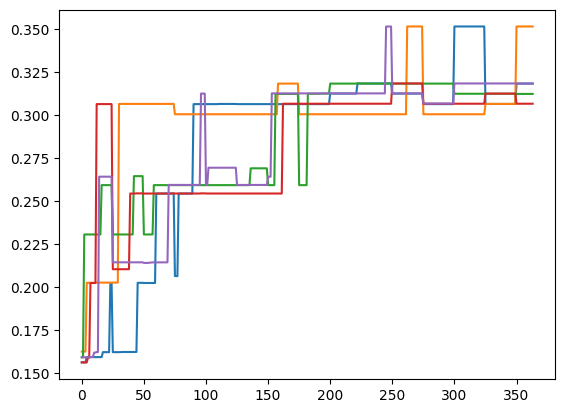

In [6]:
import matplotlib.pyplot as plt

for x in history:
    plt.plot(x)
plt.show()